In [137]:
from casadi import *

In [138]:
N = 200 # prediction horizon
gravity = 9.81
control_frequency = 10
mass = 1
thrust_weight_ratio = 2.0

opti = Opti() # Optimization problem

X = opti.variable(10, N+1) # state trajectory
U = opti.variable(4, N)   # control trajectory

X_ref = opti.parameter(10, N+1)  # Reference trajectory
U_ref = opti.parameter(4, N) # Reference controls

In [139]:
f = lambda x,u: vertcat(
    x[7],
    x[8],
    x[9],
    0.5 * ( -u[1]*x[4] - u[2]*x[5] - u[3]*x[6] ),
    0.5 * (  u[1]*x[3] + u[3]*x[5] - u[2]*x[6] ),
    0.5 * (  u[2]*x[3] - u[3]*x[4] + u[1]*x[6] ),
    0.5 * (  u[3]*x[3] + u[2]*x[4] - u[1]*x[5] ),
    2 * u[0] * ( x[3]*x[5] + x[4]*x[6] ),
    2 * u[0] * ( x[5]*x[6] - x[3]*x[4] ), 
    u[0] * (x[3]*x[3] - x[4]*x[4] -x[5]*x[5] + x[6]*x[6])  - gravity
) # dx/dt = f(x,u)

dt = 1/control_frequency
for k in range(N):
    # Runge-Kutta 4 integration
    # Discretise
    k1 = f(X[:,k],         U[:,k])
    k2 = f(X[:,k]+dt/2*k1, U[:,k])
    k3 = f(X[:,k]+dt/2*k2, U[:,k])
    k4 = f(X[:,k]+dt*k3,   U[:,k])
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
    opti.subject_to(X[:,k+1]==x_next) # ensure dynamics

# for k in range(N):
#     # Runge-Kutta 4 integration
#     # Discretise
#     x_next = X[:, k]
#     M = 4
#     dt = dt / M
#     for _ in range(M):
#         k1 = f(X[:,k],         U[:,k])
#         k2 = f(X[:,k]+dt/2*k1, U[:,k])
#         k3 = f(X[:,k]+dt/2*k2, U[:,k])
#         k4 = f(X[:,k]+dt*k3,   U[:,k])
#         x_next = x_next + dt/6*(k1+2*k2+2*k3+k4) 
#     opti.subject_to(X[:,k+1]==x_next) # ensure dynamics

In [140]:
opti.subject_to(opti.bounded(2.0,U[0, :],mass*gravity*thrust_weight_ratio)) # control is limited
opti.subject_to(opti.bounded(-6.0,U[1, :],6.0)) # angular velocity is limited
opti.subject_to(opti.bounded(-6.0,U[2, :],6.0)) # angular velocity is limited
opti.subject_to(opti.bounded(-6.0,U[3, :],6.0)) # angular velocity is limited
opti.subject_to(X[:,0] == [1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])        # Initial state
opti.subject_to(U[:,0] == [9.81*mass, 0.0, 0.0, 0.0])        # Initial state

# reference controls
reference_controls = np.tile(np.array([9.81*mass, 0.0, 0.0, 0.0]), (N, 1)).T
opti.set_value(U_ref, reference_controls)

In [141]:
Q = diag(MX([100, 100, 100, 10, 10, 10, 10, 10, 10, 10]))  # Weights for state error
R = diag(MX([0.1, 0.1, 0.1, 0.1]))  # Weights for control effort

cost = 0 # Cost function init
# Cost function calculations
for k in range(N):
    state_error = X[:, k] - X_ref[:, k]
    cost += mtimes(state_error.T, mtimes(Q, state_error))
    control_error = U[:, k] - U_ref[:, k]
    cost += mtimes(control_error.T, mtimes(R, control_error))

opti.minimize(cost)

# ipopt_options = {
#     # 'verbose': False,
#     "ipopt.tol": 1e-4,
#     "ipopt.acceptable_tol": 1e-4,
#     "ipopt.max_iter": 100,
#     # "ipopt.print_level": 0, 
#     # "print_time": False
# }

opti.solver("ipopt") # set numerical backend

In [142]:
opti.set_initial(X, 0.0) # Initial guess

current_state = np.array([1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
opti.subject_to(X[:,0] == current_state)

# start = 0.0
# end = 0.1
# step = step = (end - start) / (nmpc.n_p)
# reference_trajectory = np.zeros((nmpc.state_dim, nmpc.n_p+1))
# reference_trajectory[0] = np.arange(start, end+step, step)
# reference_trajectory[3] = 1.0
# reference_trajectory[:3] += current_state[:3, np.newaxis]

theta = np.linspace(0, 2 * np.pi, N+1)
reference_trajectory = np.vstack((np.cos(theta), np.sin(theta), np.ones_like(theta), np.ones_like(theta), np.zeros_like(theta), np.zeros_like(theta), np.zeros_like(theta), np.zeros_like(theta), np.zeros_like(theta), np.zeros_like(theta)))

opti.set_value(X_ref, reference_trajectory)
sol = opti.solve()   # actual solve


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    19024
Number of nonzeros in inequality constraint Jacobian.:      800
Number of nonzeros in Lagrangian Hessian.............:     8400

Total number of variables............................:     2810
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2024
Total number of inequality constraints...............:      800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.3924722e+04 9.81e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

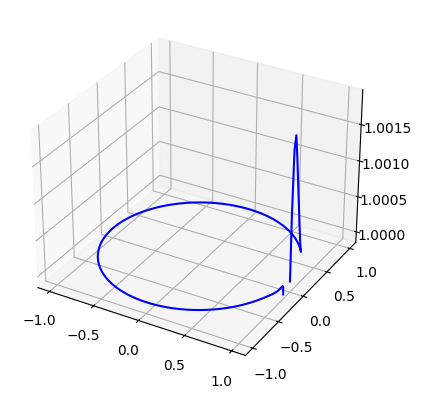

In [143]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(sol.value(X[0, :]), sol.value(X[1, :]), sol.value(X[2, :]), label='3D Line Plot', color='blue')

plt.show()

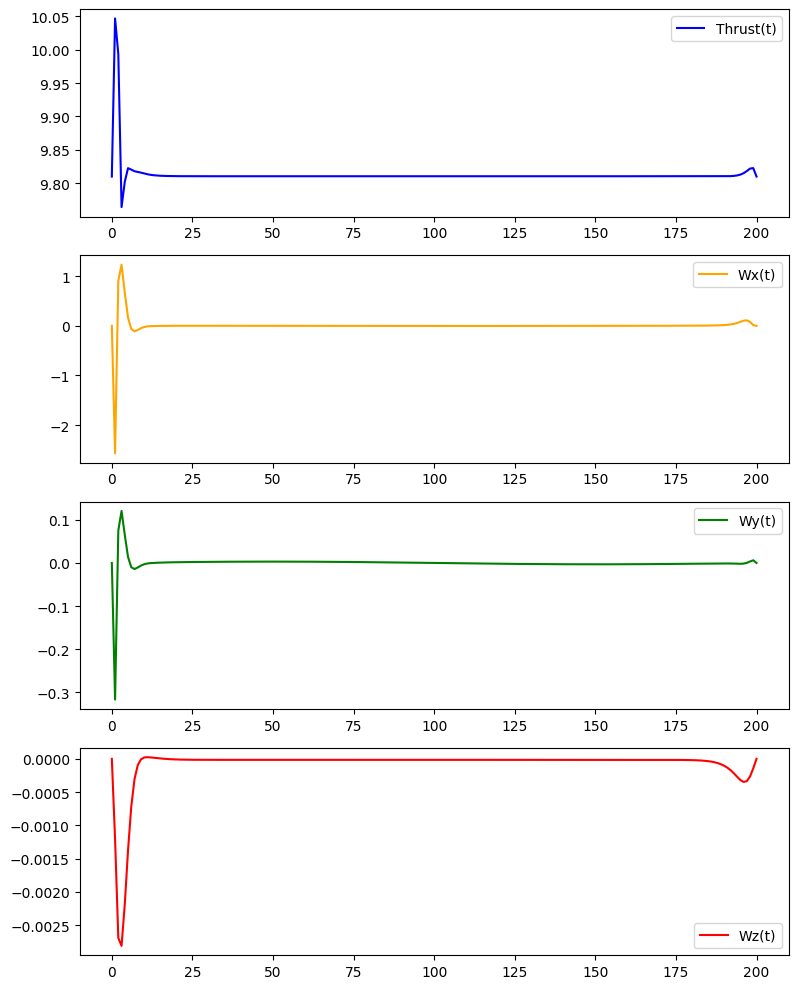

In [144]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, N, N)

fig, axs = plt.subplots(4, 1, figsize=(8, 10))

axs[0].plot(x, sol.value(U[0, :]), label="Thrust(t)", color='blue')
axs[0].legend()

axs[1].plot(x, sol.value(U[1, :]), label="Wx(t)", color='orange')
axs[1].legend()

axs[2].plot(x, sol.value(U[2, :]), label="Wy(t)", color='green')
axs[2].legend()

axs[3].plot(x, sol.value(U[3, :]), label="Wz(t)", color='red')
axs[3].legend()

plt.tight_layout()
plt.show()